In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

---

### Datos NDBC

In [3]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(os.path.join(cwd, 'data'), 'ocean')
df = pd.read_csv(os.path.join(data_path, "nbdc.txt"), delim_whitespace=True, header=0)
df = df.iloc[:, 5:]

/tmp/ipykernel_1219871/1463893536.py:3: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [4]:
freq = df.columns
freq = freq.astype(float)

data = df.to_numpy()
data = data[:, :, np.newaxis]
data.shape
num_samples, num_obs_per_sample, num_outputs = data.shape

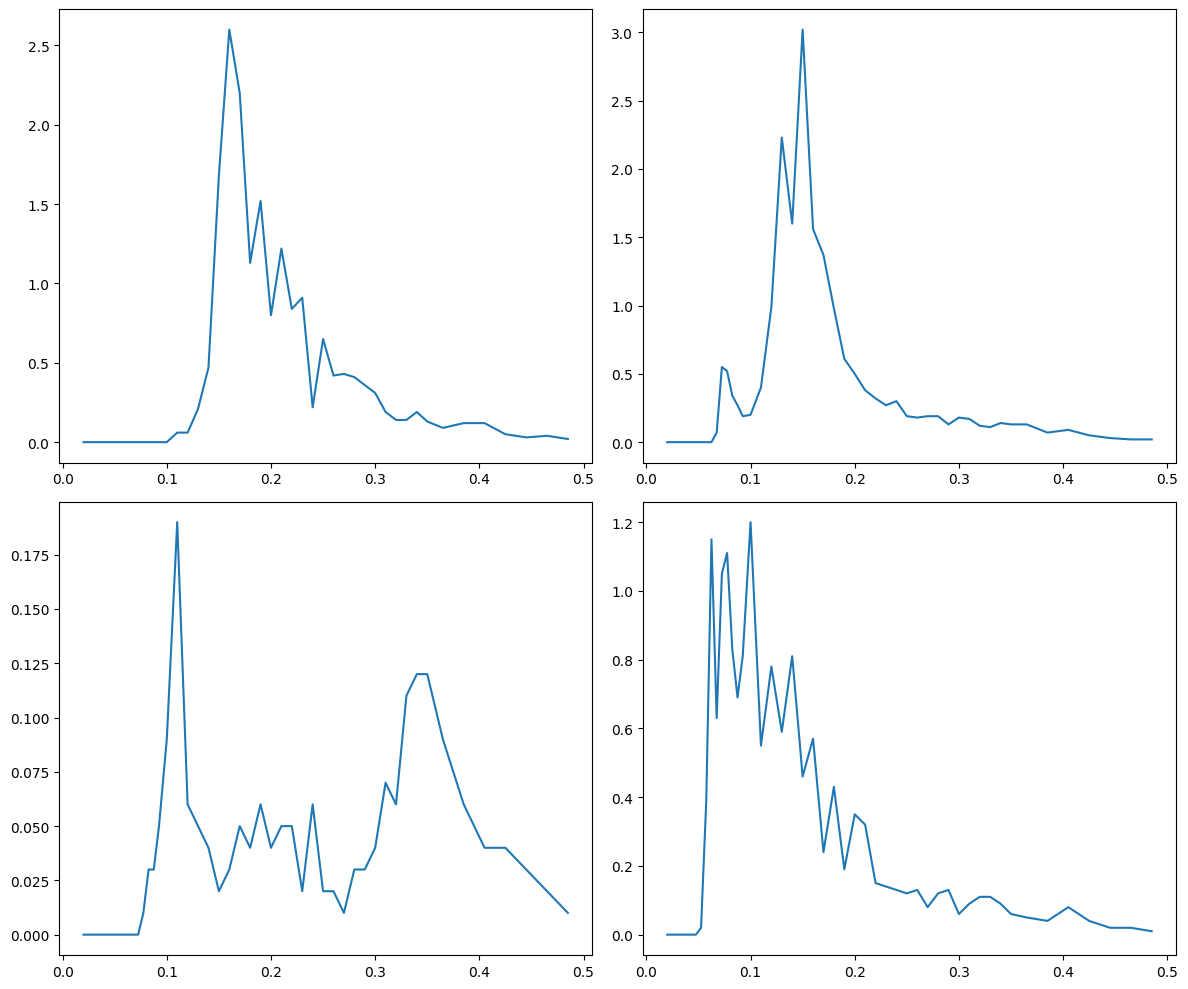

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfica 1
axs[0, 0].plot(freq, data[0, :, 0])

# Gráfica 2
axs[0, 1].plot(freq, data[127, :, 0])

# Gráfica 3
axs[1, 0].plot(freq, data[35, :, 0])

# Gráfica 4
axs[1, 1].plot(freq, data[5923, :, 0])

# Ajustar el layout para evitar superposición
plt.tight_layout()
plt.show()

Shape of hs: (8524, 1)
How much spectra falls in the range 0.5-3.0 Hs: 7787


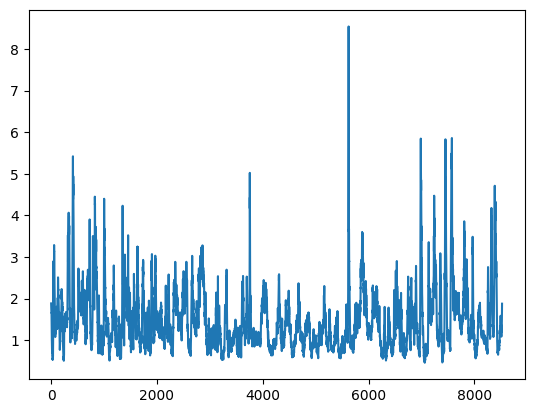

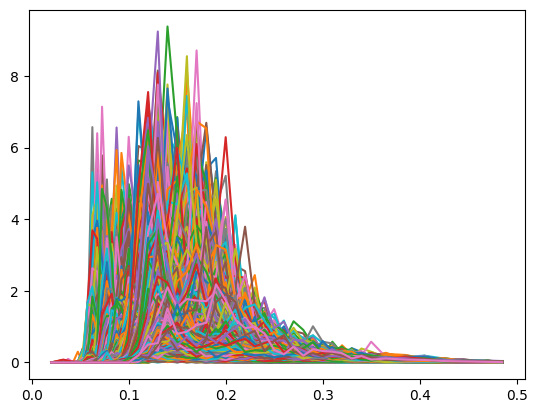

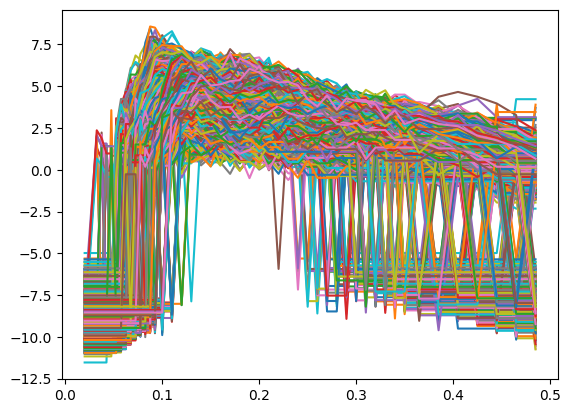

In [6]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq[1]-freq[0], num_obs_per_sample)[:, np.newaxis]
hs = 4 * np.sqrt(data[:,:,0] @ interv)
print("Shape of hs: "+str(hs.shape))
plt.plot(hs)
chosen_indexes = np.where((hs > 0.5) & (hs < 2.5))[0]
#chosen_indexes = np.arange(0, num_samples)
print("How much spectra falls in the range 0.5-3.0 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()


In [7]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(7787, 47, 1)


In [8]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=num_samples-1)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.05
std_dif = std_dif * 0.01
bound_sigma = (std * 1e-7, std * 1e-1)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-1)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.13978394852914805
Gamma estimated: 0.13978394852914805
Final sigma: 0.006989197426457403
Final gamma: 0.0013978394852914805
Final sigma bound: (6.989197426457403e-10, 0.0006989197426457404)
Final gamma bound: (1.3978394852914806e-12, 0.00013978394852914806)


In [9]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 1.0
ini_lengthscale = 1e-2
bound_lengthscale = (1e-7, 5e-1)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq[0:100]).T
x_train = np.atleast_2d(freq[0:100]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0]/2.0, dtype=np.float64)).T

(47, 1)


Sample: 0
Main model chosen: 1
---Kernel estimated---
0.54**2 * RBF(length_scale=0.00906) + WhiteKernel(noise_level=0.00064)
Sum resp_temp: [1]
Q_em: -1669.76, Q_lat: 0.00, Elbo_linear: -8.07, Elbo_LDS: -23.50
Sample: 1
Main model chosen: 1
Sum resp_temp: [2]
Q_em: -1702.66, Q_lat: -14.40, Elbo_linear: -8.10, Elbo_LDS: -33.49
Sample: 2
Birth of new model:  2
Main model chosen: 2
---Kernel estimated---
0.541**2 * RBF(length_scale=0.00871) + WhiteKernel(noise_level=0.000643)
Sum resp_temp: [2 1]
Q_em: -1702.68, Q_lat: -24.85, Elbo_linear: -4.11, Elbo_LDS: -56.99
Sample: 3
Main model chosen: 2
Sum resp_temp: [2 2]
Q_em: -1729.14, Q_lat: -29.50, Elbo_linear: -4.54, Elbo_LDS: -66.98
Sample: 4
Birth of new model:  3
Main model chosen: 3
---Kernel estimated---
0.506**2 * RBF(length_scale=0.00904) + WhiteKernel(noise_level=0.000647)
Sum resp_temp: [2 2 1]
Q_em: -1729.15, Q_lat: -39.96, Elbo_linear: -4.99, Elbo_LDS: -90.48
Sample: 5
Birth of new model:  4
Main model chosen: 4
---Kernel estimate

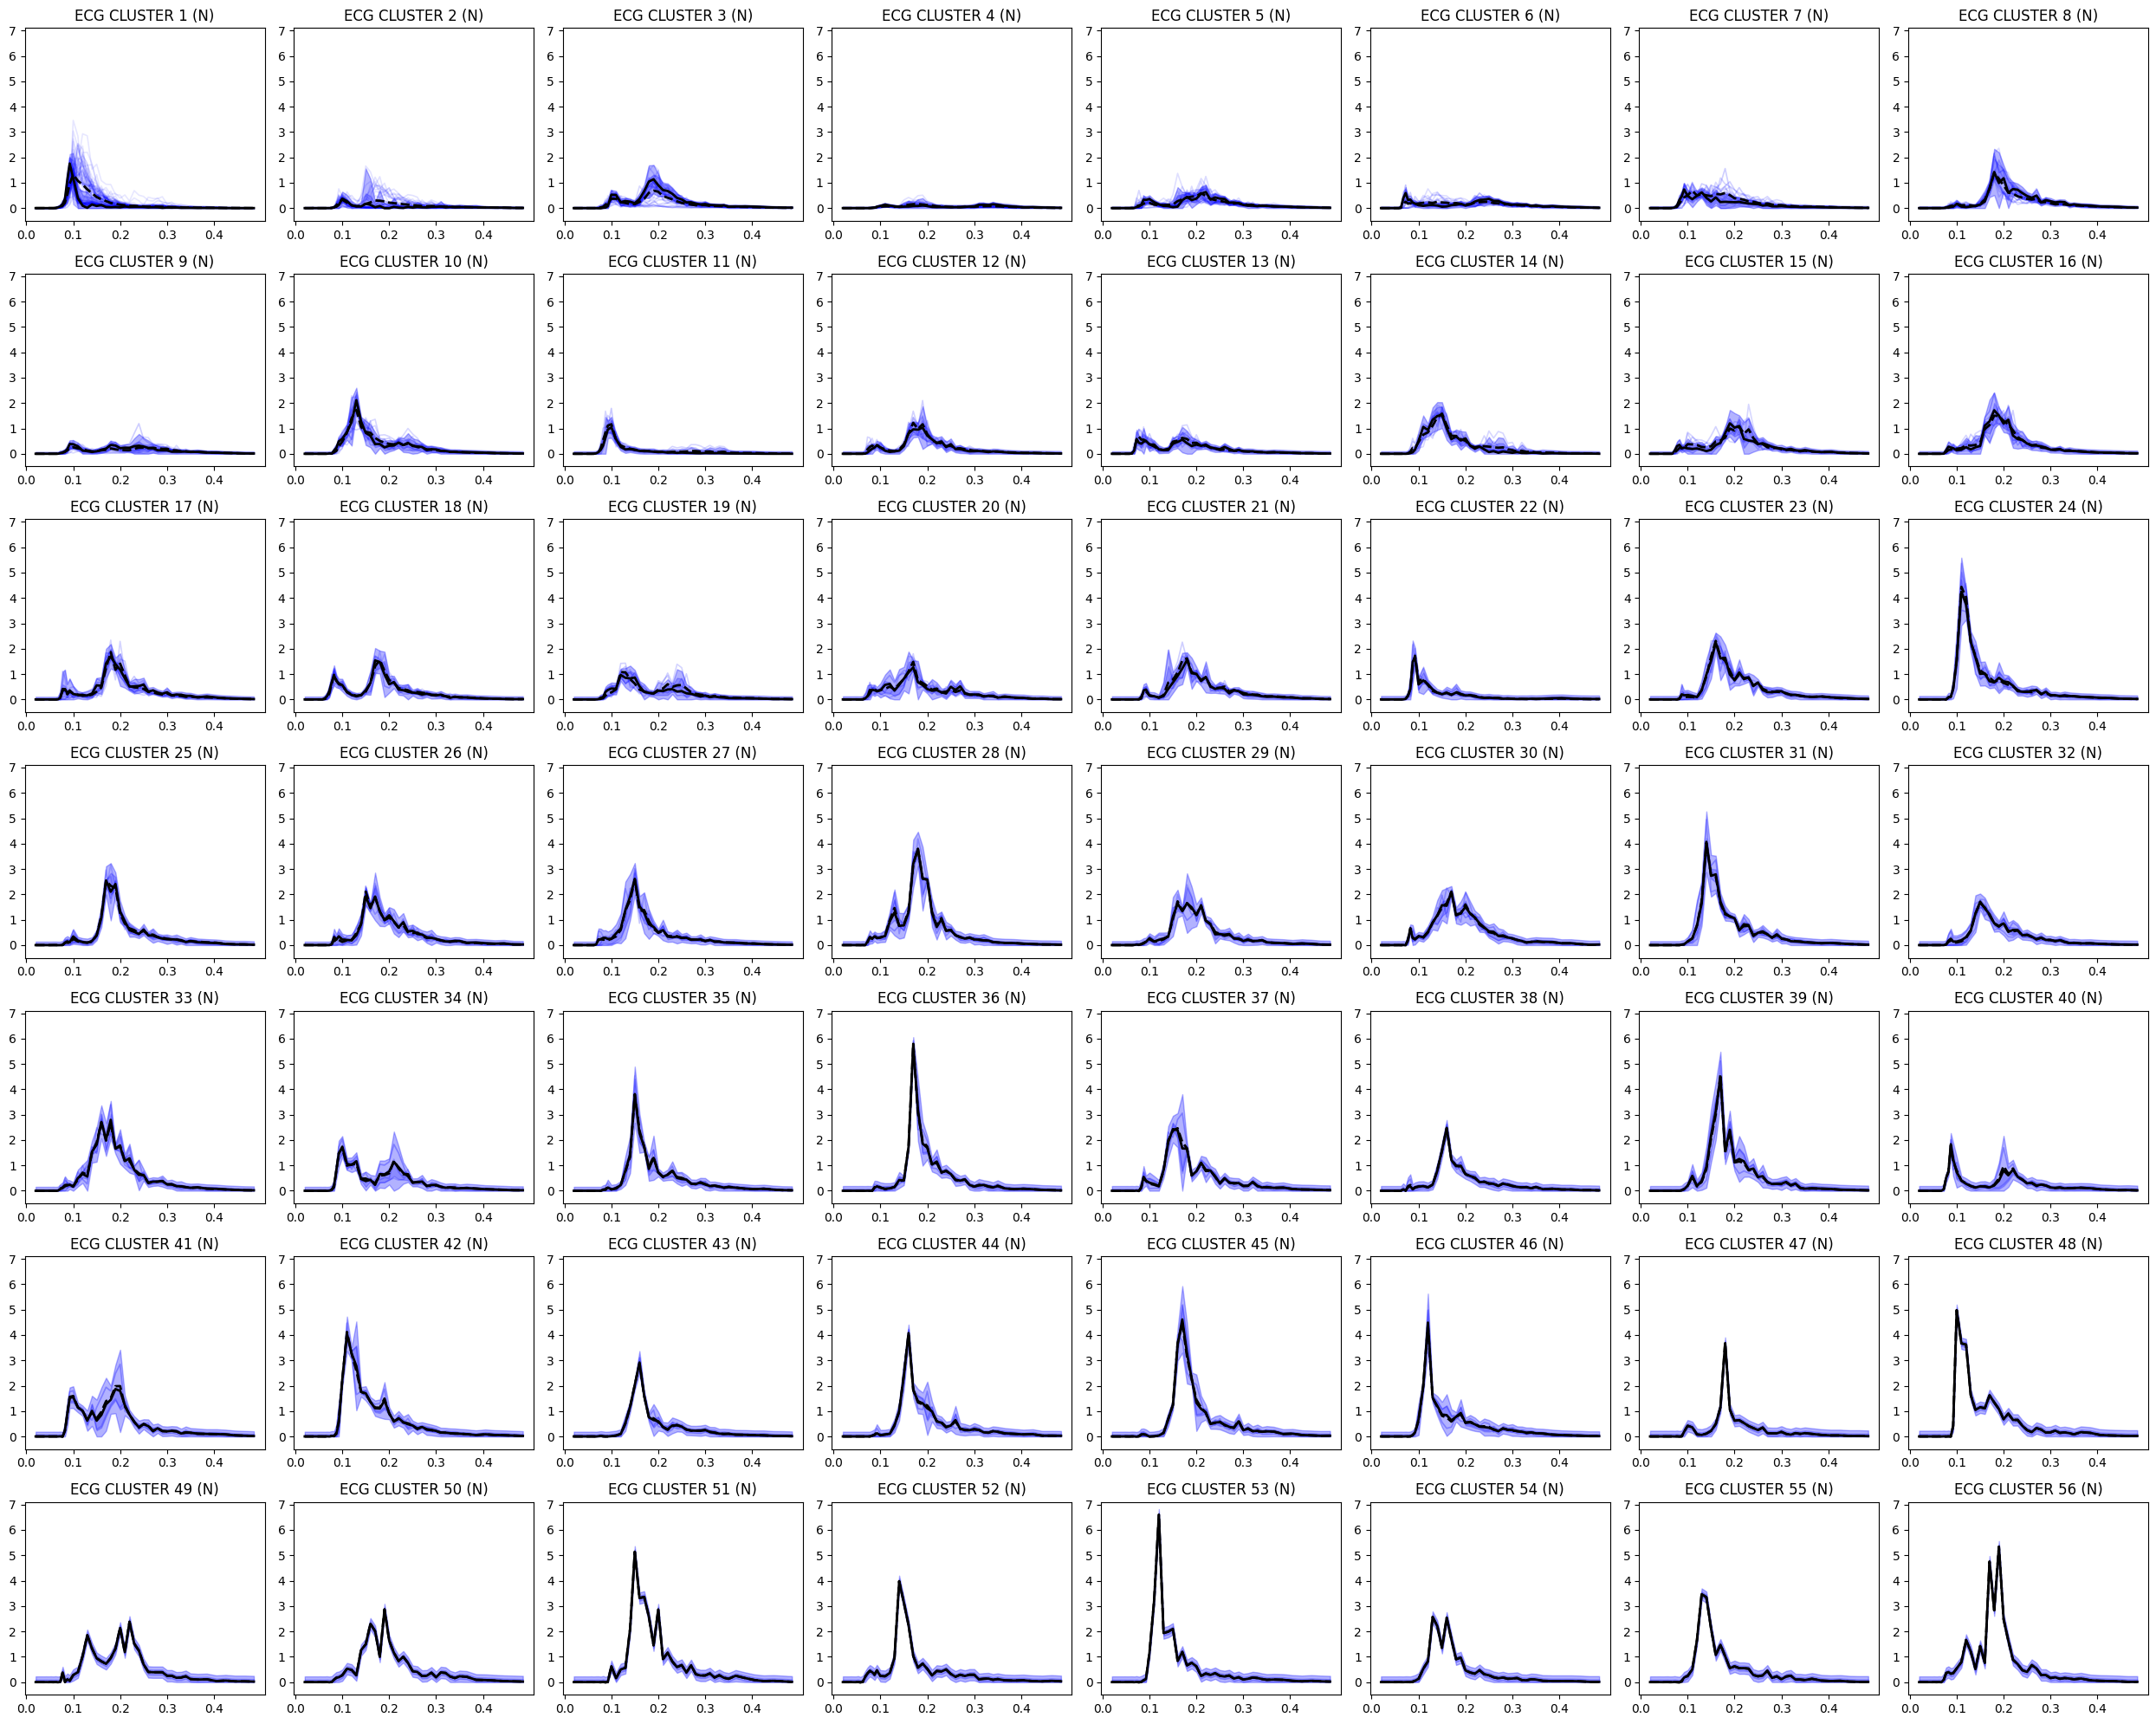

In [10]:
sw_gp_online = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, estimation_limit=None, annealing=True, free_deg_MNIV=5)

#Generate artificial labels to plot using util_plots.
from hdpgpc.util_plots import print_results, plot_models_plotly
num_samples = data.shape[0]
labels = np.array(['N'] * num_samples)
#mean_data = np.mean(data, axis=1)[:, np.newaxis]
#data_ = data - mean_data
for t in range(400):
    print("Sample: "+str(t))
    sw_gp_online.include_sample(x_train, data[t], with_warp=warp)
main_model = print_results(sw_gp_online, labels, 0, error=False)
selected_gpmodels = sw_gp_online.selected_gpmodels()
plot_models_plotly(sw_gp_online, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0], plot_latent=True, ticks=True, yscale=True)

In [11]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=20, free_deg_MNIV=5)

#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp.include_batch(x_trains, data[:num_samples,:,[0]])

------ HDP Hyperparameters ------
gamma: 0.8
transAlpha: 0.8
startAlpha: 0.8
kappa: 0.0
---------------------------------
Group responsability estimated: [7787]
---Kernel estimated---
0.54**2 * RBF(length_scale=0.00906) + WhiteKernel(noise_level=0.00064)

-----------Lead 1-----------
Step 1/20- Trying to divide: 0 with beat 7174
---Kernel estimated---
0.873**2 * RBF(length_scale=0.00943) + WhiteKernel(noise_level=0.000646)
Sum resp_temp: [7649  142]
Q_em: -185962.78, Q_lat: -6917175.89, Elbo_linear: -7531.96, Elbo_LDS: -35540.40

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
>>> Q_all_loop -------
Sum resp_temp: [7649  142]
Q_em: -185962.78, Q_lat: -6917175.89, Elbo_linear: -7531.96, Elbo_LDS: -35540.40
Sum resp_temp: [7627  163]
Q_em: -184289.72, Q_lat: -6878842.24, Elbo_linear: -11337.98, Elbo_LDS: -37479.99
Sum resp_temp: [7627  163]
Q_em: -184289.72, Q_lat: -6878842.24, Elbo_linear: -11337.98, Elbo_LDS: -37479.99
ELBO_reduction: 34

Model 1 : MainModel: N : [N-1536]
Model 2 : MainModel: N : [N-965]
Model 3 : MainModel: N : [N-907]
Model 4 : MainModel: N : [N-778]
Model 5 : MainModel: N : [N-707]
Model 6 : MainModel: N : [N-505]
Model 7 : MainModel: N : [N-391]
Model 8 : MainModel: N : [N-386]
Model 9 : MainModel: N : [N-354]
Model 10 : MainModel: N : [N-252]
Model 11 : MainModel: N : [N-138]
Model 12 : MainModel: N : [N-137]
Model 13 : MainModel: N : [N-125]
Model 14 : MainModel: N : [N-100]
Model 15 : MainModel: N : [N-100]
Model 16 : MainModel: N : [N-63]
Model 17 : MainModel: N : [N-60]
Model 18 : MainModel: N : [N-60]
Model 19 : MainModel: N : [N-56]
Model 20 : MainModel: N : [N-46]
Model 21 : MainModel: N : [N-38]
Model 22 : MainModel: N : [N-32]
Model 23 : MainModel: N : [N-9]
Model 24 : MainModel: N : [N-6]
Model 25 : MainModel: N : [N-12]
Model 26 : MainModel: N : [N-9]
Model 27 : MainModel: N : [N-9]
Model 28 : MainModel: N : [N-6]
Classification error: 0 / 7787 -- 0.00000


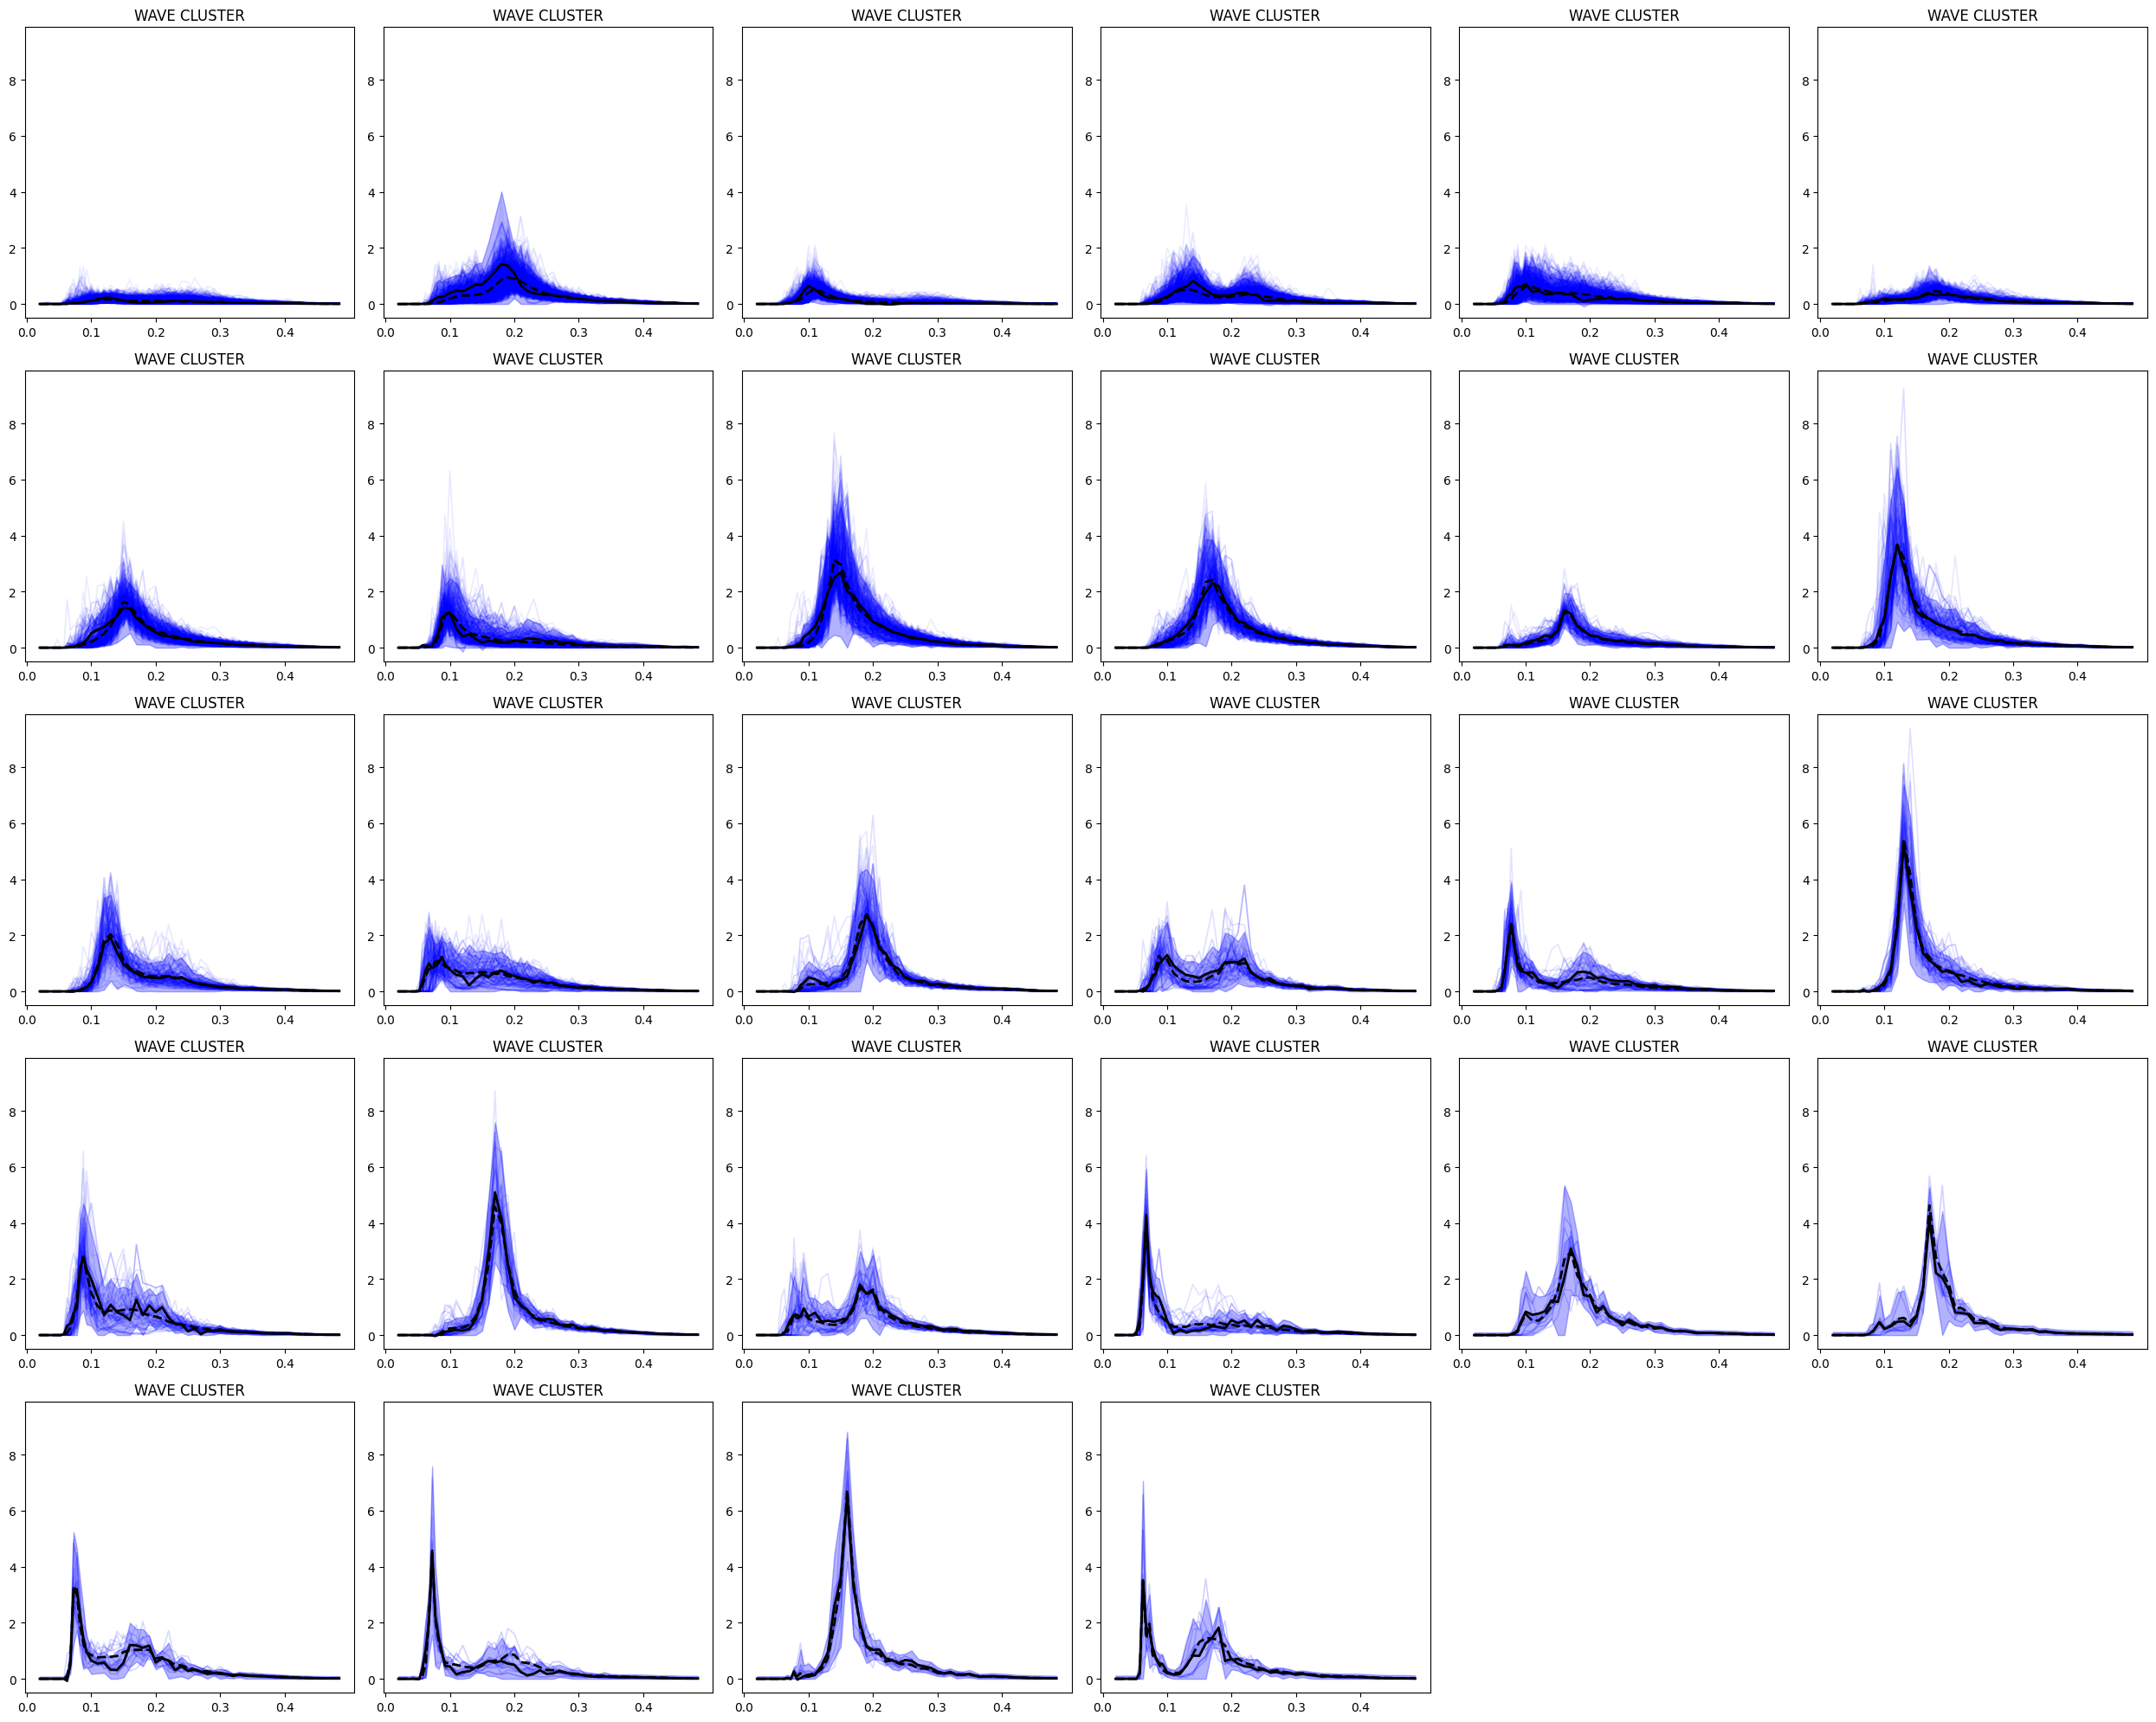

In [12]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_ndbc.png")

Model 1 : MainModel: N : [N-1536]
Model 2 : MainModel: N : [N-965]
Model 3 : MainModel: N : [N-907]
Model 4 : MainModel: N : [N-778]
Model 5 : MainModel: N : [N-707]
Model 6 : MainModel: N : [N-505]
Model 7 : MainModel: N : [N-391]
Model 8 : MainModel: N : [N-386]
Model 9 : MainModel: N : [N-354]
Model 10 : MainModel: N : [N-252]
Model 11 : MainModel: N : [N-138]
Model 12 : MainModel: N : [N-137]
Model 13 : MainModel: N : [N-125]
Model 14 : MainModel: N : [N-100]
Model 15 : MainModel: N : [N-100]
Model 16 : MainModel: N : [N-63]
Model 17 : MainModel: N : [N-60]
Model 18 : MainModel: N : [N-60]
Model 19 : MainModel: N : [N-56]
Model 20 : MainModel: N : [N-46]
Model 21 : MainModel: N : [N-38]
Model 22 : MainModel: N : [N-32]
Model 23 : MainModel: N : [N-9]
Model 24 : MainModel: N : [N-6]
Model 25 : MainModel: N : [N-12]
Model 26 : MainModel: N : [N-9]
Model 27 : MainModel: N : [N-9]
Model 28 : MainModel: N : [N-6]
Classification error: 0 / 7787 -- 0.00000


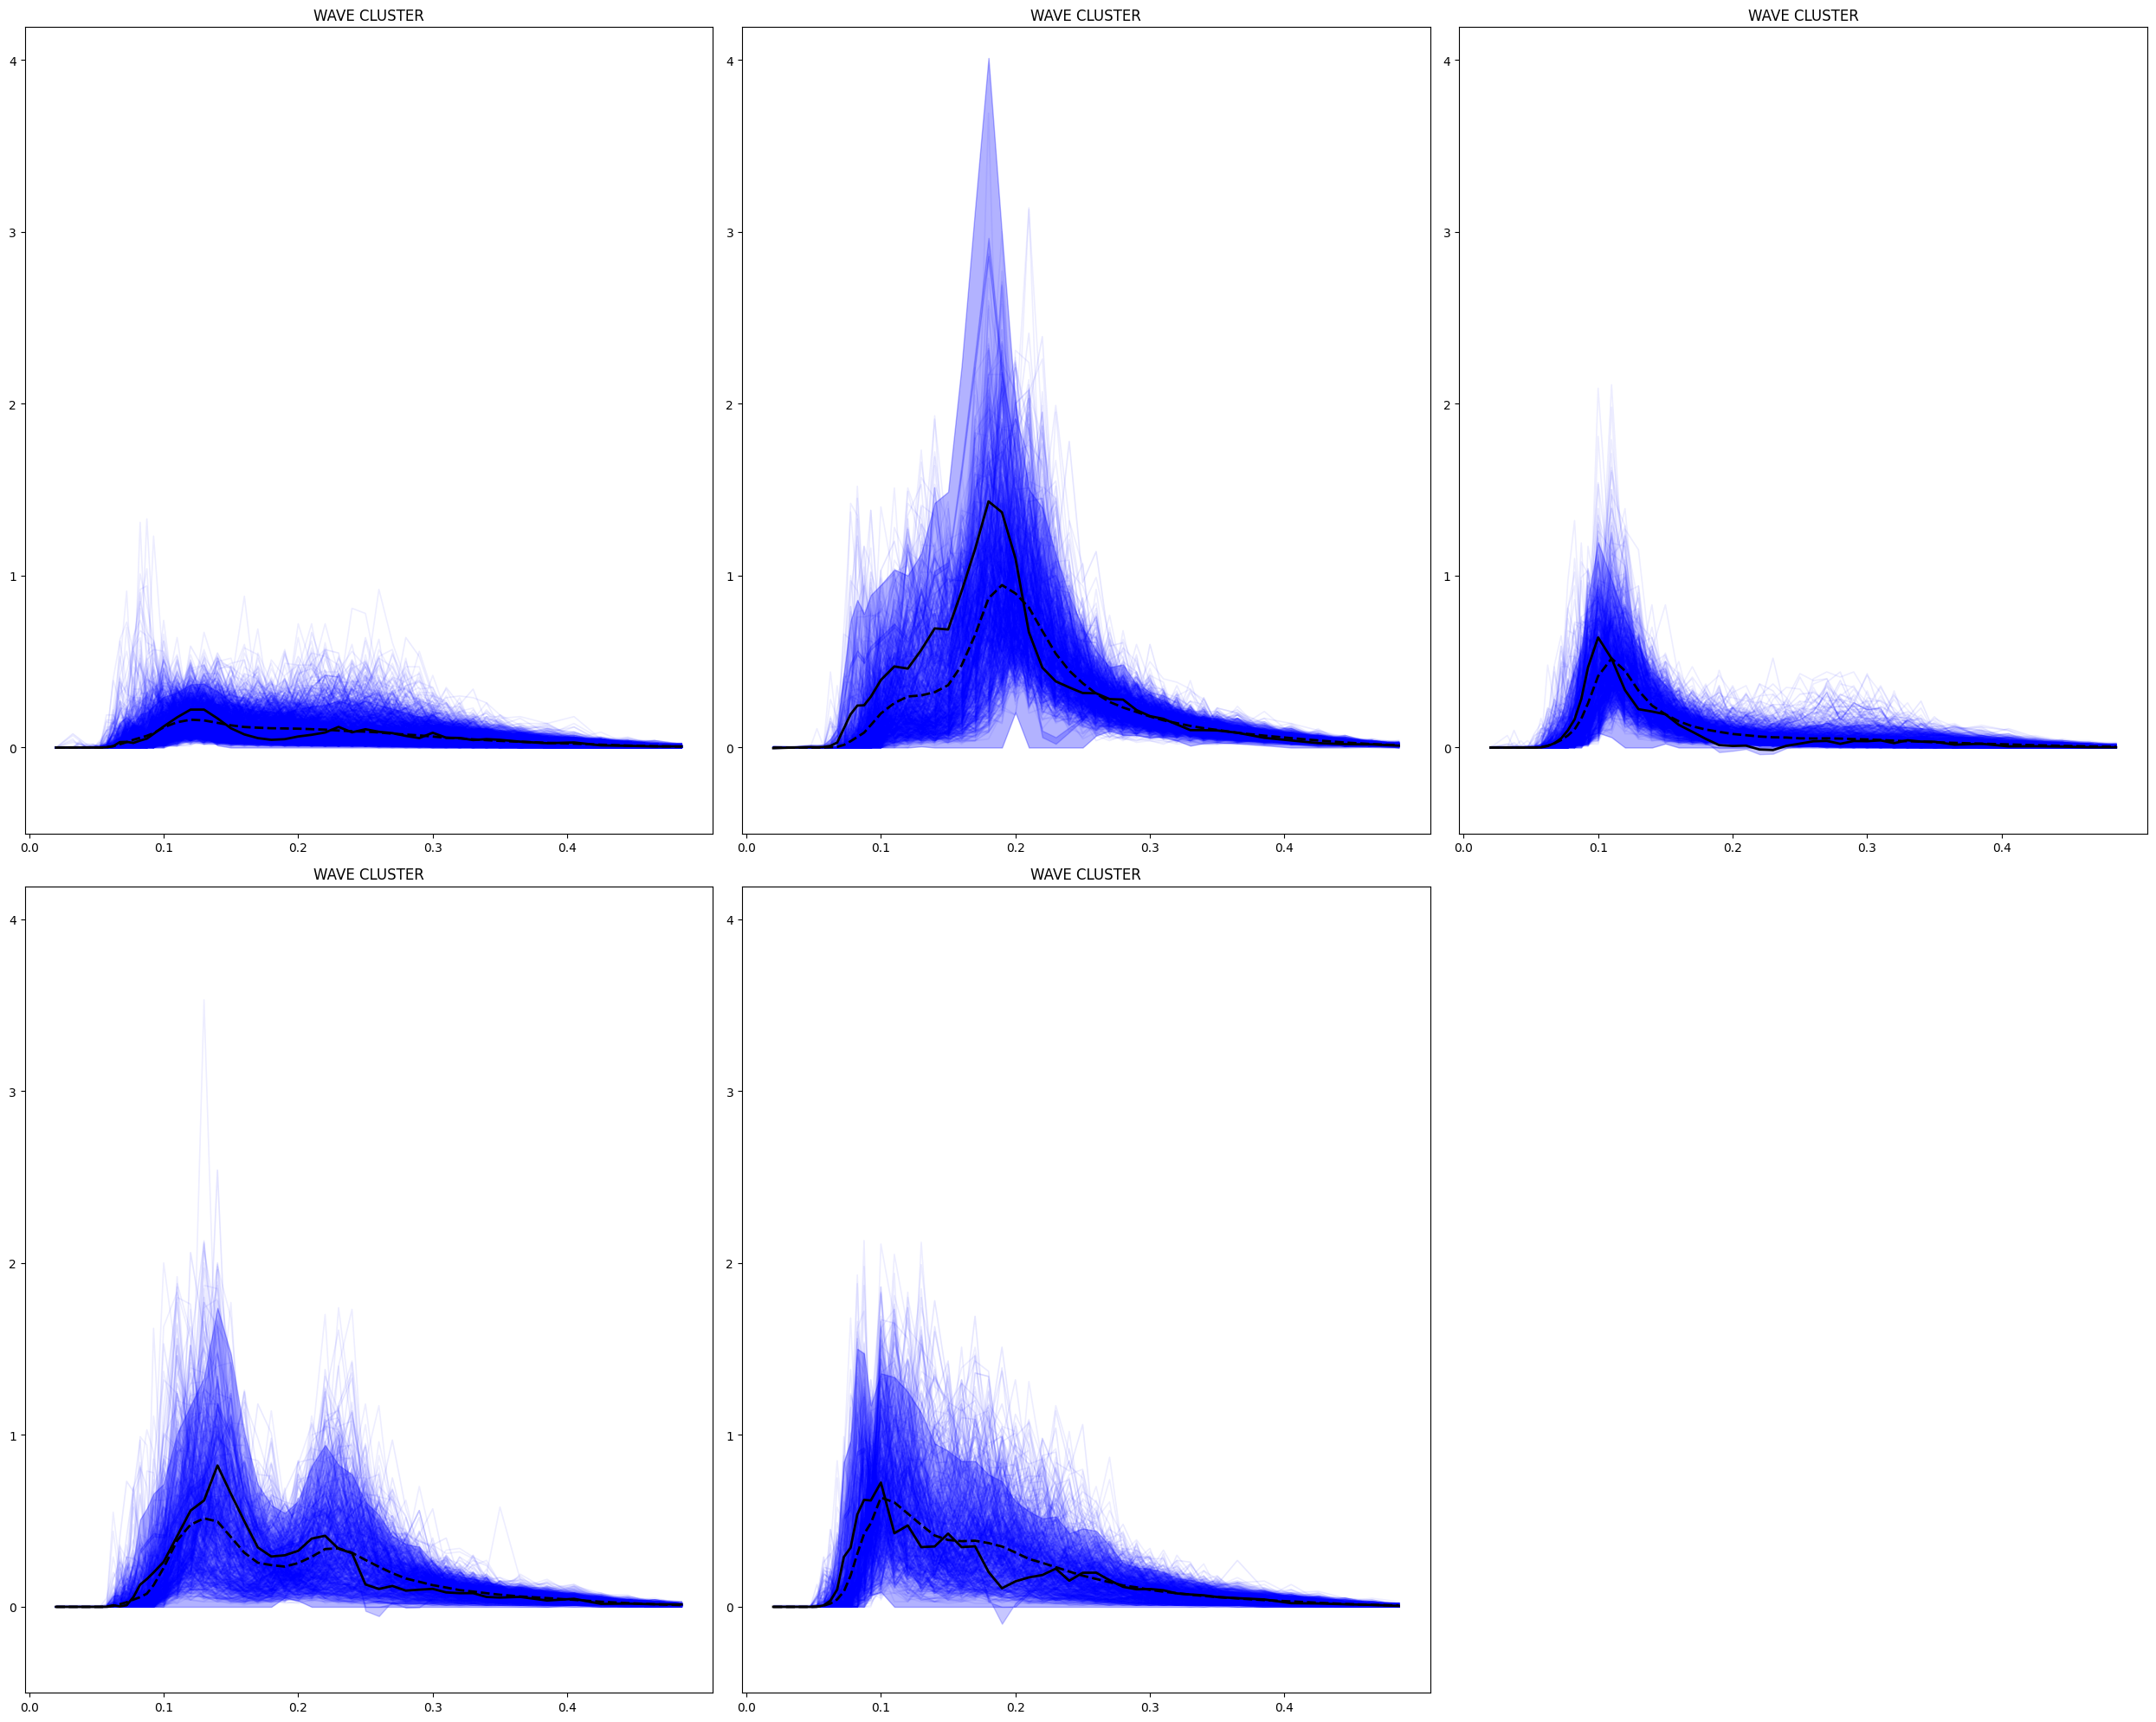

In [13]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels[:5], main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_ndbc.png")

GIF saved as 'function_evolution.gif'


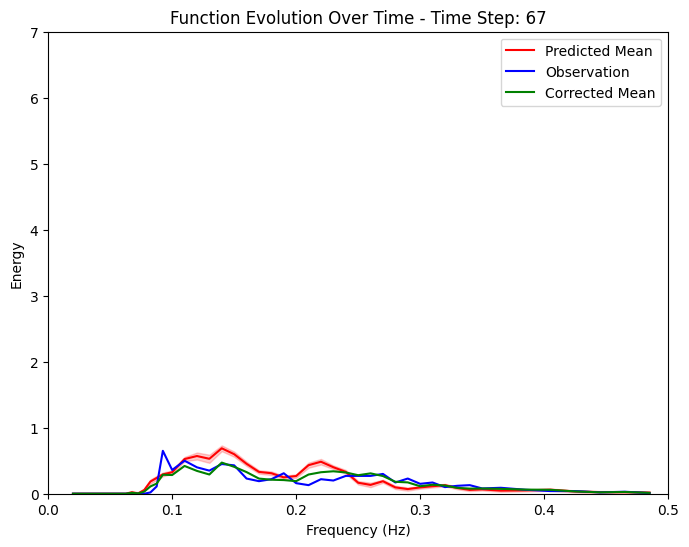

In [14]:
from hdpgpc.util_plots import FunctionEvolutionVisualizer

gp = sw_gp.gpmodels[0][3]
initial_step = 53
num_steps = 15 * 4  # Number of time steps to simulate

# Create visualizer instance
visualizer = FunctionEvolutionVisualizer(gp, initial_step, num_steps)

# Generate animation and save as GIF
visualizer.create_animation(output_filename="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/function_evolution.gif")
print("GIF saved as 'function_evolution.gif'")

import pickle as plk
with open("sw_gp_ndbc.plk", 'wb') as inp:
    plk.dump(sw_gp, inp)